In [2]:
print("Starting Imports")
import cv2
import numpy as np
import os
from scipy import stats as stats
from skimage.transform import rescale
from skimage import filters
import matplotlib.pyplot as plt

Starting Imports


In [52]:
def load_images(folder="Training"):
    images = []
    count = 0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img_hsv = rescale(cv2.cvtColor(img, cv2.COLOR_BGR2HSV),0.25, anti_aliasing=False, multichannel=True).reshape(76800,3)
            
            images.extend(img_hsv)
            
    return np.array(images)



# Data and global variable preparation

In [5]:
x_train = load_images("Training")
y_train = load_images("Labels")[:,2]
y_mask = np.where(y_train==1.0, 1.0, 0.0)

x_coins_mask = np.zeros_like(x_train)
x_desk_mask = np.zeros_like(x_train)

for i in np.arange(3):
    x_coins_mask[:,i] = x_train[:,i] * y_mask
    x_desk_mask[:,i] = x_train[:,i] - x_coins_mask[:,i]

x_coins = []
x_desk = []

black = x_coins_mask[0]

for i in np.arange(len(x_coins_mask)):
    
    if not (x_coins_mask[i] == black).all():
        
        x_coins.append(x_coins_mask[i])
        
    if not (x_desk_mask[i] == black).all():
        
        x_desk.append(x_desk_mask[i])
    
x_coins = np.array(x_coins)
x_desk = np.array(x_desk)
I_coins = x_coins.shape[0]
I_desk = x_desk.shape[0]
x_shape = x_coins[0].shape


# Helper Functions

In [6]:
def plot_image(x):
    plt.imshow(x.reshape(240,320,3))
    plt.axis("off")
def plot_mask(x):
    plt.imshow(x.reshape(240,320))
def reshape_mask(x):
    return x.reshape(240,320)
    

# Expectation Maximization

In [8]:
def Estep(x_train,Mu_h, Sigma_h,Lamda,R):
    
    print("Starting E-step")
    for i in np.arange(R.shape[0]):
                
            normalization = 0.0
            
            for j in np.arange(R.shape[1]):

                normalization += Lamda[j]*stats.multivariate_normal.pdf(x_train[i],mean=Mu_h[j],cov=Sigma_h[j])

                
            for k in np.arange(R.shape[1]):

                R[i][k] = Lamda[k]*stats.multivariate_normal.pdf(x_train[i],mean=Mu_h[k],cov=Sigma_h[k]) / normalization
    return R           

def Mstep(x_train,R, Lamdas, Sigmas):
    
    print("Starting M-step")
  
    lamdas = np.sum(R, axis=0) / np.sum(R)
    
    
    mus = np.dot(x_train.T,R) / np.sum(R,axis=0)
    mus = mus.T
    
    sigmas = np.zeros(Sigmas.shape)
    for k in np.arange(R.shape[1]):
        
        col_rik = R[:,k]
        val = (x_train - mus[k])**2
        
        cov = np.dot(col_rik, val) /np.sum(R[:,k])
        sigmas[k] = np.diag(cov)
    return lamdas,mus,sigmas

def Classify(x, Lamda, Mu, Sigma, theta= 0.9):
    
    prediction = 0.0
    for j in np.arange(len(Lamda)):

        prediction += Lamda[j]*stats.multivariate_normal.pdf(x,mean=Mu[j],cov=Sigma[j])
    
    
    return prediction
    




# Learning Algorithm and Experiment setup

In [73]:
def GMM_train(K, max_iter):

    k=K
    
    print("Starting Experiment woth k = ", k)
    
    Mu_coins = np.random.uniform(size=(k,x_shape[0],)) # K x N x M
    Sigma_coins = []
    for j in np.arange(k):
        Sigma_coins.append(np.eye(3))
    Sigma_coins = np.array(Sigma_coins)
    Lamda_coins = np.random.uniform(size=(k,1))
    Lamda_coins /= np.sum(Lamda_coins)
    R_coins = np.zeros(shape=(I_coins,k))

    Mu_desk = np.random.uniform(size=(k,x_shape[0],)) # K x N x M
    Sigma_desk = []
    for j in np.arange(k):
        Sigma_desk.append(np.eye(3))
    Sigma_desk = np.array(Sigma_desk)
    Lamda_desk = np.random.uniform(size=(k,1))
    Lamda_desk /= np.sum(Lamda_desk)
    R_desk = np.zeros(shape=(I_desk,k))
    result_array = []
    for i in np.arange(max_iter):
        R_coins = Estep(x_coins,Mu_coins, Sigma_coins,Lamda_coins,R_coins)
        Lamda_coins,Mu_coins,Sigma_coins = Mstep(x_coins,R_coins, Lamda_coins,Sigma_coins)
        R_desk = Estep(x_desk,Mu_desk, Sigma_desk,Lamda_desk,R_desk)
        Lamda_desk,Mu_desk,Sigma_desk = Mstep(x_desk,R_desk, Lamda_desk,Sigma_desk)

        density_coins = Classify(x_train, Lamda_coins,Mu_coins,Sigma_coins, theta=0.00001)
        density_desk = Classify(x_train, Lamda_desk,Mu_desk,Sigma_desk, theta=0.00001)

        p_coin = density_coins / (density_coins + density_desk) # Bayes' Rule
        mask = np.where(p_coin > filters.threshold_otsu(p_coin), 1.0,0)

        result = y_mask - mask
        
        FP = np.where(result==-1.0, 1,0)
        FN = np.where(result==1.0,1,0)
        correct = np.where(result==0,1,0)

        TN = correct * np.where(y_mask ==0.0,1,0)

        TP = correct * np.where(y_mask ==1.0,1,0)

        fp = np.sum(FP)
        fn = np.sum(FN)
        tp = np.sum(TP)
        tn = np.sum(TN)
        
        result_array.append((fp,fn,tp,tn))
        print("Precision", tp/(tp+fp))
        print("Recall", tp/(tp+fn))
        print("Accuracy", (tp+tn)/(tp+fp+tn+fn))
    return result_array , (Lamda_coins, Mu_coins,Sigma_coins), (Lamda_desk, Mu_desk,Sigma_desk)

In [74]:
def run_experiments():
    results = []
    for i in range(2,11,1):
        results.append(GMM_train(i,10))
        np.save("results", results, allow_pickle=True)

# Generate Graphs

In [75]:
def plot_data(data, y_label):
    
    for i in np.arange(len(data)):
    
        plt.plot( range(1,11),data[i], label=i+2)
    plt.xlabel("EM iteration")
    plt.ylabel(y_label)
    plt.legend(loc='best')
    plt.savefig(y_label)
    plt.show()
    
def generate_graphs():

    data = np.load("results.npy")
    fp = data[:,:,0]
    fn = data[:,:,1]
    tp = data[:,:,2]
    tn = data[:,:,3]
    precision = tp/ (tp+fp)
    recall = tp / (tp+fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    plot_data(precision, "Precision")
    plot_data(recall, "Recall")
    plot_data(accuracy, "Accuracy")    

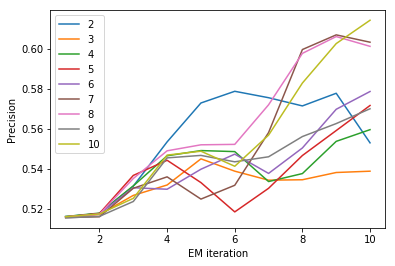

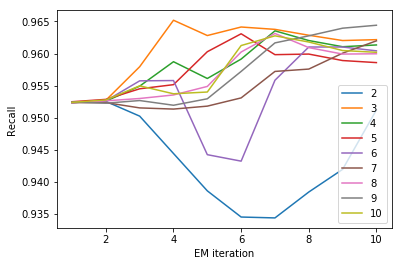

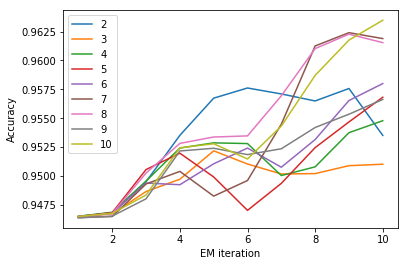

In [76]:
generate_graphs()

# Testing method

In [77]:
def mask(x, test=False):
    
    _ , coin_params, desk_params = np.load("final_model.npy")
    
    Lamda_coins,Mu_coins,Sigma_coins = coin_params
    Lamda_desk,Mu_desk,Sigma_desk = desk_params
    
    density_coins = Classify(x, Lamda_coins,Mu_coins,Sigma_coins, theta=0.00001)
    density_desk = Classify(x, Lamda_desk,Mu_desk,Sigma_desk, theta=0.00001)

    p_coin = density_coins / (density_coins + density_desk) # Bayes' Rule
    mask = np.where(p_coin > filters.threshold_otsu(p_coin), 1.0,0)
    
    return mask

def evaluate_mask(mask, label):

        result = label - mask
        
        FP = np.where(result==-1.0, 1,0)
        FN = np.where(result==1.0,1,0)
        correct = np.where(result==0,1,0)

        TN = correct * np.where(label ==0.0,1,0)

        TP = correct * np.where(label ==1.0,1,0)

        fp = np.sum(FP)
        fn = np.sum(FN)
        tp = np.sum(TP)
        tn = np.sum(TN)
        
        
        
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        accuracy = (tp+tn)/(tp+fp+tn+fn)
        
        return np.array([precision, recall , accuracy])
    
def test():
    
    x_test = load_images("Test_images")
    y_test = load_images("Test_labels")[:,2]
    y_mask = np.where(y_test==1.0, 1.0, 0.0)
    num_images = int(x_test.shape[0]/76800)
    final = np.array([0.,0.,0.])
    for i in np.arange(num_images):
        
        lower = 76800 * i
        upper = 76800 * (i+1)
        result = evaluate_mask(mask(x_test[lower:upper]), y_mask[lower:upper]) 
        final += result
    final /= num_images
    print(final)
    return final

In [65]:
test()

[0.74250514 0.96215788 0.97276414]


array([0.74250514, 0.96215788, 0.97276414])